---
title: Overview
description: Juno Orbits and Sunspot Numbers
---

Snunspot data

> We suggest as minimum short-format credit : "Source: WDC-SILSO, Royal Observatory of Belgium, Brussels". or "Sunspot data from the World Data Center SILSO, Royal Observatory of Belgium, Brussels".  

In [1]:
import matplotlib.pyplot as plt
import scienceplots

from space_analysis.utils.cdas import Variables
from space_analysis.plot.basic import savefig
import pandas as pd
import polars as pl

from matplotlib.pyplot import Axes

plt.rc("savefig", dpi=300)
plt.rc('figure.subplot', wspace = 0, hspace = 0)

In [4]:
timerange = ["2011-08-01", "2016-07-01"]
fname = "juno-hg-loc_sunspot-number"

datasets = ['JUNO_HELIO1DAY_POSITION', 'EARTH_HELIO1DAY_POSITION', 'STA_HELIO1DAY_POSITION']
names = ['JUNO', 'EARTH', 'STA']

## Plotting Juno and other mission location

In [5]:
dfs = []

for dataset, name in zip(datasets, names):
    ds_variables = Variables(
        dataset=dataset,
        timerange=timerange,
    )
    df = ds_variables.to_pandas()
    df = df.rename(columns={c: f"{name}_{c}" for c in df.columns})
    dfs.append(df)

2024-02-08 23:52:27.545 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - RAD_AU
2024-02-08 23:52:27.546 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - SE_LAT
2024-02-08 23:52:27.546 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - SE_LON
2024-02-08 23:52:27.546 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - HG_LAT
2024-02-08 23:52:27.547 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - HG_LON
2024-02-08 23:52:27.547 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - HGI_LAT
2024-02-08 23:52:27.548 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - HGI_LON
2024-02-08 23:52:28.326 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - RAD_AU
2024-02-08 23:52:28.327 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - SE_LAT
2024-02-08 23:52:28.327 | INFO     | space_analysis.utils.cdas:get_dataset_variables:25 - SE_LON
2024-02-08 23:52:28.328 | IN

In [6]:
df_concated = pd.concat(dfs, axis=1)

In [7]:
df = pl.DataFrame(df_concated.reset_index()).with_columns(
    JUNO_EARTH_HGI_LON_diff = (pl.col("JUNO_HGI_LON") - pl.col("EARTH_HGI_LON")).abs(),
    JUNO_STA_HGI_LON_diff = (pl.col("JUNO_HGI_LON") - pl.col("STA_HGI_LON")).abs(),
    JUNO_EARTH_HG_LON_diff = (pl.col("JUNO_HG_LON") - pl.col("EARTH_HG_LON")).abs(),
    JUNO_STA_HG_LON_diff = (pl.col("JUNO_HG_LON") - pl.col("STA_HG_LON")).abs(),
).with_columns(
    JUNO_EARTH_HG_LON_diff = pl.when(pl.col("JUNO_EARTH_HG_LON_diff")>180).then(360-pl.col("JUNO_EARTH_HG_LON_diff")).otherwise(pl.col("JUNO_EARTH_HG_LON_diff")),
    JUNO_STA_HG_LON_diff = pl.when(pl.col("JUNO_STA_HG_LON_diff")>180).then(360-pl.col("JUNO_STA_HG_LON_diff")).otherwise(pl.col("JUNO_STA_HG_LON_diff")),
)

In [83]:
def plot_lon_diff(df,ax: Axes):
    ax.plot(df["Epoch"], df["JUNO_EARTH_HG_LON_diff"], label="Earth")
    ax.plot(df["Epoch"], df["JUNO_STA_HG_LON_diff"], label="STA")
    ax.set_ylabel("HG Longitude\nDifference\n[deg]")

## Plotting a solar cycle index

https://docs.sunpy.org/en/stable/generated/gallery/plotting/solar_cycle_example.html

In [ ]:
%pip install "sunpy[net, timeseries]"

In [10]:
from astropy.time import Time

import sunpy.timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.time import TimeRange

08-Feb-24 23:52:31: /Users/zijin/micromamba/envs/cool_planet/lib/python3.10/site-packages/drms/version.py:25: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  for j, piece in enumerate(LooseVersion(version).version[:3]):



The U.S. Dept. of Commerce, NOAA, Space Weather Prediction Center (SWPC)
provides recent solar cycle indices which includes different sunspot numbers,
radio flux, and geomagnetic index. They also provide predictions for how the
sunspot number and radio flux will evolve. Predicted values are based on the
consensus of the Solar Cycle 24 Prediction Panel.

We will first search for and then download the data.



In [ ]:
time_range = TimeRange(timerange)
result = Fido.search(a.Time(time_range), a.Instrument('noaa-indices'))
f_noaa_indices = Fido.fetch(result)

noaa = ts.TimeSeries(f_noaa_indices, source='noaaindices').truncate(time_range)

We then load them into individual `~sunpy.timeseries.TimeSeries` objects.



Finally, we plot both ``noaa`` and ``noaa_predict`` for the sunspot number.
In this case we use the S.I.D.C. Brussels International Sunspot Number (RI).
The predictions provide both a high and low values, which we plot below as
ranges.



In [84]:

def plot_sunspot_number(noaa_indices_ts, ax):
    
    time : Time = noaa_indices_ts.time
    time = time.to_datetime()
    
    ax.scatter(time, noaa_indices_ts.quantity('sunspot RI'))
    ax.plot(time, noaa_indices_ts.quantity('sunspot RI'), label='Monthly')
    ax.plot(
        time, noaa_indices_ts.quantity('sunspot RI smooth'), label='Smoothed'
    )
    
    ax.set_ylim(bottom=0)
    ax.set_ylabel('Sunspot\nNumber\n[#]')

## Plotting OMNI and STEREO plasma data

In [1]:
import sys
import yaml

from space_analysis.ds.tplot import Config, export, process_panel, plot

file_path = 'omni_stereo.yml'
config = yaml.load(open(file_path), Loader=yaml.FullLoader)
config = Config(**config)
tvars2plot = []

In [2]:
for p_config in config.panels:
    tvar2plot = process_panel(p_config)
    tvars2plot.append(tvar2plot)

08-Feb-24 23:52:12: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hourly/2011/
08-Feb-24 23:52:13: File is current: /Users/zijin/data/omni/hourly/2011/omni2_h0_mrg1hr_20110701_v01.cdf
08-Feb-24 23:52:13: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hourly/2012/
08-Feb-24 23:52:13: File is current: /Users/zijin/data/omni/hourly/2012/omni2_h0_mrg1hr_20120101_v01.cdf
08-Feb-24 23:52:13: File is current: /Users/zijin/data/omni/hourly/2012/omni2_h0_mrg1hr_20120701_v01.cdf
08-Feb-24 23:52:13: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hourly/2013/
08-Feb-24 23:52:13: File is current: /Users/zijin/data/omni/hourly/2013/omni2_h0_mrg1hr_20130101_v01.cdf
08-Feb-24 23:52:14: File is current: /Users/zijin/data/omni/hourly/2013/omni2_h0_mrg1hr_20130701_v01.cdf
08-Feb-24 23:52:14: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hourly/2014/
08-Feb-24 23:52:14: File is

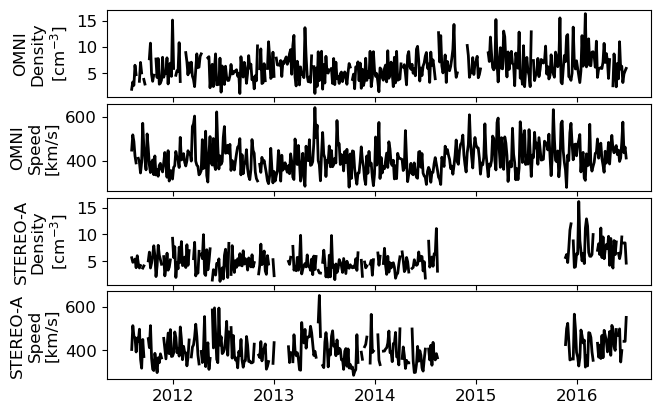

In [20]:
fig, axes = plot(tvars2plot, config)
fig

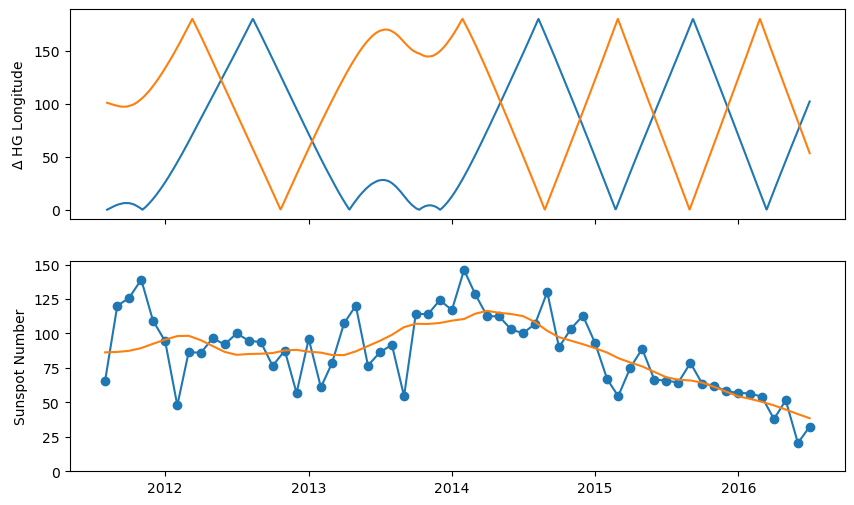

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 6))

plot_lon_diff(df, axes[0])
plot_sunspot_number(noaa, axes[1])

## Overview plot

In [ ]:
def unify_axes_fontsize(axes, fontsize=8):
    for ax in axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                    ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fontsize)

09-Feb-24 00:39:00: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
09-Feb-24 00:39:00: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
09-Feb-24 00:39:00: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
09-Feb-24 00:39:00: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


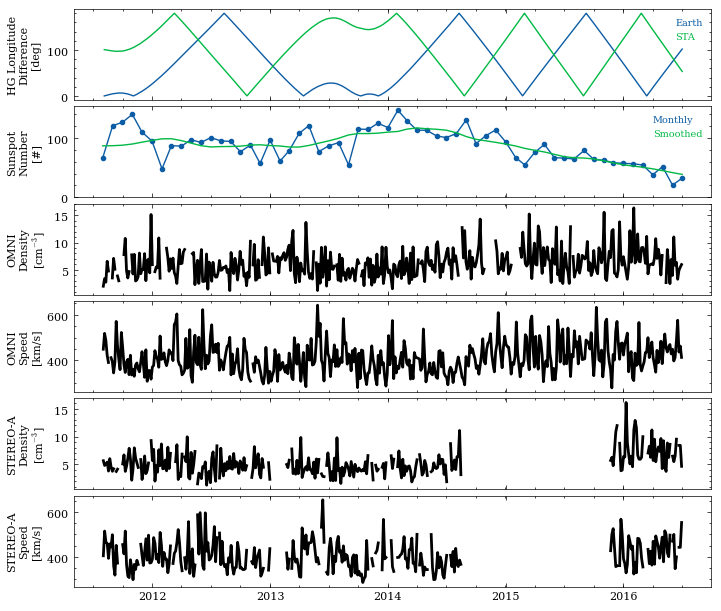

In [85]:
#| label: fig-hg-sunspot
with plt.style.context(['science', 'nature', 'no-latex']):
    fig, axes = plt.subplots(nrows=6, ncols=1, sharex=True, figsize=(7.5, 7.5))

    plot_lon_diff(df, axes[0])
    plot_sunspot_number(noaa, axes[1])
    plot(tvars2plot=tvars2plot, fig=fig, axes=axes[2:], config=config)
    
    for ax in axes:
        legend = ax.legend(handletextpad=0, handlelength=0)
    
        for line, text in zip(legend.get_lines(),legend.get_texts()):
            text.set_color(line.get_color())
    
    unify_axes_fontsize(axes, fontsize=8)
    # plt.subplots_adjust(wspace=0, hspace=0)
    
    savefig(fname)

fig

    